# Training2

In this notebook file, ResizedData-FaceOnly dataset will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

A deep learning model based on MobileNet architecture will be created.

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#Person dataframe in ResizeData is being read from md5 file
personDf = pd.read_pickle("../../../Data/ResizedData/Person.pkl")
personDf

,Name
ID,
0,Abdullah Gul
1,Adrien Brody
2,Ahmed Chalabi
3,Ai Sugiyama
4,Alan Greenspan
...,...
418,Yasser Arafat
419,Yoko Ono
420,Yoriko Kawaguchi


In [5]:
#FaceOnly Training data is being read from md5 file
trainingDf = pd.read_pickle("../../../Data/ResizedData/FaceOnly/Training.pkl")
trainingDf

,PersonID,ImageBGR,DetectionType
0,22,"[[[71, 116, 99], [69, 116, 98], [67, 115, 98],...",SingleFace
1,125,"[[[10, 24, 36], [12, 26, 38], [18, 32, 44], [2...",NoFace
2,356,"[[[177, 199, 204], [176, 199, 204], [175, 200,...",SingleFace
3,277,"[[[91, 103, 121], [91, 104, 122], [92, 105, 12...",SingleFace
4,131,"[[[42, 65, 81], [38, 61, 77], [30, 53, 68], [2...",SingleFace
...,...,...,...
4151,4,"[[[64, 89, 93], [62, 88, 92], [60, 86, 90], [5...",SingleFace
4152,120,"[[[114, 93, 71], [116, 96, 74], [122, 101, 79]...",SingleFace
4153,322,"[[[197, 207, 207], [196, 208, 210], [195, 207,...",NoFace
4154,383,"[[[7, 5, 5], [7, 5, 5], [8, 5, 5], [8, 6, 6], ...",SingleFace


In [6]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Converting pixel values to range [-1, 1] in this section is an option
#Doing this once over the entire array now will be save time
#This is not how the conversion will be done because of some memory problems in this project
#Images are of data type np.uint8 when they are in the range [0, 255]
#np.uint8 requires 1 byte memory while np.float32 requires 4 byte and np.float64 requires 8 byte
#See https://www.educba.com/numpy-data-types/
#When np.uint8 data type, images use about 1GB memory
#Even if these pixel values are converted to np.float32 data type, it will need about 4GB of memory
#The computer used for this project has 8GB Ram
#Considering operating system requirements, memory required by the model, etc. 8GB Ram is not enough for this process
#For this reason, this method is not preferred, although it will save time

trainingX = np.array(trainingDf.ImageBGR.values.tolist())
trainingX.shape

(4156, 224, 224, 3)

In [7]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.PersonID.values.tolist()).reshape((-1,1))
trainingY.shape

(4156, 1)

In [8]:
#FaceOnly Validation data is being read from md5 file
validationDf = pd.read_pickle("../../../Data/ResizedData/FaceOnly/Validation.pkl")
validationDf

,PersonID,ImageBGR,DetectionType
0,171,"[[[64, 65, 56], [93, 94, 85], [143, 144, 135],...",SingleFace
1,120,"[[[102, 116, 110], [106, 120, 114], [115, 129,...",SingleFace
2,196,"[[[23, 40, 43], [23, 40, 43], [24, 41, 44], [2...",SingleFace
3,95,"[[[34, 55, 63], [35, 56, 65], [38, 59, 69], [4...",MultipleFace
4,380,"[[[227, 227, 227], [227, 227, 227], [227, 227,...",SingleFace
...,...,...,...
909,71,"[[[104, 116, 120], [103, 116, 121], [102, 117,...",SingleFace
910,183,"[[[35, 17, 10], [35, 17, 11], [36, 17, 12], [3...",SingleFace
911,120,"[[[109, 141, 160], [105, 137, 156], [97, 129, ...",SingleFace
912,120,"[[[84, 94, 111], [81, 91, 108], [76, 86, 103],...",SingleFace


In [9]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

#Converting pixel values to range [-1, 1] in this section is an option
#Doing this once over the entire array now will be save time
#This is not how the conversion will be done because of some memory problems in this project
#Images are of data type np.uint8 when they are in the range [0, 255]
#np.uint8 requires 1 byte memory while np.float32 requires 4 byte and np.float64 requires 8 byte
#See https://www.educba.com/numpy-data-types/
#When np.uint8 data type, images use about 1GB memory
#Even if these pixel values are converted to np.float32 data type, it will need about 4GB of memory
#The computer used for this project has 8GB Ram
#Considering operating system requirements, memory required by the model, etc. 8GB Ram is not enough for this process
#For this reason, this method is not preferred, although it will save time

validationX = np.array(validationDf.ImageBGR.values.tolist())
validationX.shape

(914, 224, 224, 3)

In [10]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.PersonID.values.tolist()).reshape((-1,1))
validationY.shape

(914, 1)

In [11]:
#MobileNet Block is being defined as a method to avoid code duplication
def MobileNetBlock(model : tf.keras.models.Sequential, filters : int, strides : int) -> tf.keras.models.Sequential:
    model.add(tf.keras.layers.DepthwiseConv2D(kernel_size = 3, strides = strides, padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    model.add(tf.keras.layers.Conv2D(filters, kernel_size = 1, strides = 1, padding = "same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    
    return model

In [12]:
#sequential model is being created
model = tf.keras.models.Sequential()

#input layer
model.add(tf.keras.layers.Input(shape = trainingX[0].shape))

#Conv2D block
model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, strides = 2, padding = "same"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.ReLU())

#First MobileNet Block
MobileNetBlock(model, 64, 1)

#Second MobileNet Block
MobileNetBlock(model, 128, 2)

#Third MobileNet Block
MobileNetBlock(model, 128, 1)

#Fourth MobileNet Block
MobileNetBlock(model, 256, 2)

#Fifth MobileNet Block
MobileNetBlock(model, 256, 1)

#Sixth MobileNet Block
MobileNetBlock(model, 512, 2)

#Seventh MobileNet Block
MobileNetBlock(model, 512, 1)

#Eighth MobileNet Block
MobileNetBlock(model, 512, 1)

#Ninth MobileNet Block
MobileNetBlock(model, 512, 1)

#Tenth MobileNet Block
MobileNetBlock(model, 512, 1)

#Eleventh MobileNet Block
MobileNetBlock(model, 512, 1)

#Twelfth MobileNet Block
MobileNetBlock(model, 1024, 2)

#Thirteenth MobileNet Block
MobileNetBlock(model, 1024, 1)

#AveragePooling Layer
model.add(tf.keras.layers.AveragePooling2D(pool_size = 7, strides = 1, data_format='channels_last'))

#Output Layer
model.add(tf.keras.layers.Dense(personDf.shape[0], activation = tf.nn.softmax))

#summary of model is being printed
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu (ReLU)                 (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      2

In [13]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [14]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize):
        self.image, self.label = image, label
        self.batchSize = batchSize
        self.index = np.arange(self.image.shape[0])
    
    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return int(np.ceil(self.image.shape[0] / float(self.batchSize)))
    
    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        #Before being sent to the model on demand pixel values will be converted to range [-1, 1]
        #Doing this operation here means that it will be repeated as many epochs for each image and this wastes time
        #This is how the conversion is being done because of some memory problem in this project
        batchX = (self.image[indexPart] / 127.5) - 1
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #At the end of the epoch, the index array is being shuffled 
        #so that the data in the next epoch is returned in different orders
        np.random.shuffle(self.index)

In [15]:
#model is being trained with 35 epochs and 16 batchSize using GPU
#A small batchSize value is being chosen to prevent GPU memory problem
#Large batchSize reduce training time while also generally providing better results
with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, 16),
        epochs = 35,
        validation_data = FitSequence(validationX, validationY, 16)
    )

Epoch 1/35
260/260 [==============================] - 188s 575ms/step - loss: 5.7965 - accuracy: 0.0751 - val_loss: 5.3984 - val_accuracy: 0.0944
Epoch 2/35
260/260 [==============================] - 142s 546ms/step - loss: 5.3424 - accuracy: 0.0645 - val_loss: 6.0017 - val_accuracy: 0.0944
Epoch 3/35
260/260 [==============================] - 156s 598ms/step - loss: 5.0128 - accuracy: 0.0412 - val_loss: 12.5945 - val_accuracy: 0.0174
Epoch 4/35
260/260 [==============================] - 151s 579ms/step - loss: 4.5852 - accuracy: 0.0334 - val_loss: 6.5163 - val_accuracy: 0.0184
Epoch 5/35
260/260 [==============================] - 151s 580ms/step - loss: 4.0686 - accuracy: 0.0310 - val_loss: 5.1630 - val_accuracy: 0.0215
Epoch 6/35
260/260 [==============================] - 183s 705ms/step - loss: 3.5321 - accuracy: 0.0316 - val_loss: 4.7268 - val_accuracy: 0.0352
Epoch 7/35
260/260 [==============================] - 169s 649ms/step - loss: 2.9389 - accuracy: 0.0356 - val_loss: 5.6412 

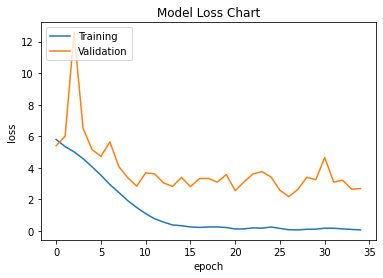

In [16]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

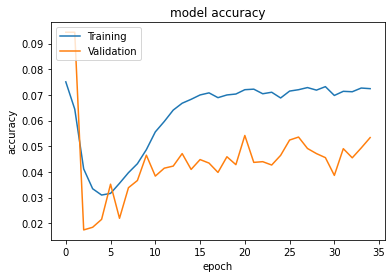

In [17]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [18]:
#FaceOnly Test data is being read from md5 file
testDf = pd.read_pickle("../../../Data/ResizedData/FaceOnly/Test.pkl")
testDf

,PersonID,ImageBGR,DetectionType
0,270,"[[[0, 2, 13], [0, 1, 11], [0, 0, 8], [0, 0, 7]...",SingleFace
1,80,"[[[9, 11, 22], [9, 11, 23], [10, 12, 25], [11,...",SingleFace
2,14,"[[[43, 69, 53], [32, 58, 42], [13, 37, 22], [6...",SingleFace
3,120,"[[[161, 124, 104], [160, 124, 105], [159, 125,...",SingleFace
4,401,"[[[8, 15, 142], [7, 15, 142], [6, 15, 142], [6...",SingleFace
...,...,...,...
910,291,"[[[157, 175, 176], [152, 170, 173], [143, 161,...",SingleFace
911,302,"[[[76, 82, 89], [76, 82, 89], [77, 82, 90], [7...",MultipleFace
912,401,"[[[39, 42, 46], [38, 41, 45], [37, 40, 44], [3...",SingleFace
913,340,"[[[11, 16, 25], [11, 16, 24], [12, 15, 23], [1...",SingleFace


In [19]:
#testX is being extracted from testDf as wanted shape
testX = np.array(testDf.ImageBGR.values.tolist())
testX.shape

(915, 224, 224, 3)

In [20]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.PersonID.values.tolist()).reshape((-1,1))
testY.shape

(915, 1)

In [21]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, 16))

58/58 [==============================] - 7s 120ms/step - loss: 2.9544 - accuracy: 0.0507


In [22]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 2.9544482231140137


In [23]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.0506814606487751


# Training2 Inference

By looking at the charts, it can be seen that learning does not take place.

The loss value, decreased as it should for the Training data, while there was no smooth decrease for the Validation data.

It can be said that this is a kind of overfitting.

On the other hand, the accuracy of the model remained around 7% even for Training data.

The model has not learned enough to have any success even on the Training data.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.

Since there is no expectation from this unprocessed dataset, which is already imbalanced.

This training will not be focussed on.